In [1]:
import sys
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import time
from typing import Union, List, Sequence, Optional
from tqdm import trange

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
import QES.general_python.common.binary as Binary
from QES.general_python.algebra.utils import JAX_AVAILABLE, get_backend, get_global_logger
from QES.general_python.common.plot import Plotter

# ------------------------------------------------------------------
#! Lattice
from QES.general_python.lattices.lattice import LatticeBC, Lattice
from QES.general_python.lattices.honeycomb import HoneycombLattice
from QES.general_python.lattices.square import SquareLattice

# ------------------------------------------------------------------
#! Sampler
import QES.Solver.MonteCarlo.sampler as Sampler
import QES.NQS.nqs as NQS

# ------------------------------------------------------------------
#! Networks
from QES.general_python.ml.net_impl.networks.net_rbm import RBM
from QES.general_python.ml.net_impl.networks.net_cnn import CNN
from QES.general_python.ml.net_impl.activation_functions import relu_jnp, tanh_jnp, sigmoid_jnp, leaky_relu_jnp, elu_jnp, poly6_jnp, softplus_jnp

# ------------------------------------------------------------------
#! Hamiltonians
from QES.Algebra.Model.dummy import DummyHamiltonian
from QES.Algebra.Model.Interacting.Spin.heisenberg_kitaev import HeisenbergKitaev
from QES.Algebra.Model.Interacting.Spin.transverse_ising import TransverseFieldIsing

# ------------------------------------------------------------------
#! Linear algebra
import QES.general_python.algebra.solvers.stochastic_rcnfg as SR
import QES.general_python.algebra.solvers as solvers
import QES.general_python.algebra.preconditioners as preconditioners

# ------------------------------------------------------------------

#! Spin operators
import QES.Algebra.Operator.operators_spin as op_spin
#! Fermionic operators
import QES.Algebra.Operator.operators_spinless_fermions as op_sferm

#! Backends
if JAX_AVAILABLE:
    import jax
    import jax.numpy as jnp
else:
    jax = None
    jnp = None

# ------------------------------------------------------------------
logger              = get_global_logger()
backend             = 'jax'
seed                = 1234
dtypex              = jnp.complex128
be_modules          = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

12_05_2025_15-10_58 [INFO] Log file created: ./log/QES_12_05_2025_15-10_58.log
12_05_2025_15-10_58 [INFO] Log level set to: info
12_05_2025_15-10_58 [INFO] ############Global logger initialized.############
12_05_2025_15-10_59 [INFO] JAX backend available and successfully imported
12_05_2025_15-10_59 [INFO] 	JAX 64-bit precision enabled.
12_05_2025_15-10_59 [INFO] Setting JAX as the active backend.
12_05_2025_15-10_59 [INFO] **************************************************
12_05_2025_15-10_59 [INFO] Backend Configuration:
12_05_2025_15-10_59 [INFO] 		NumPy Version: 1.26.4
12_05_2025_15-10_59 [INFO] 		SciPy Version: 1.13.1
12_05_2025_15-10_59 [INFO] 		JAX Version: 0.5.3
12_05_2025_15-10_59 [INFO] 		Active Backend: jax
12_05_2025_15-10_59 [INFO] 			JAX Available: True
12_05_2025_15-10_59 [INFO] 			Default Seed: 42
12_05_2025_15-10_59 [INFO] 		JAX Backend Details:
12_05_2025_15-10_59 [INFO] 				Main Module: jax.numpy
12_05_2025_15-10_59 [INFO] 				Random Module: jax.random (+ PRNGKey)
1

### Lattice interface

In [29]:
ham_dtype   = jnp.float64
lx          = 3
ly          = 2
lattice     = SquareLattice(
                    dim = 2, 
                    lx  = lx,
                    ly  = ly,
                    lz  = 1, 
                    bc  = LatticeBC.PBC
                )
lattice     = HoneycombLattice(
                    dim = 2,
                    lx  = lx,
                    ly  = ly,
                    lz  = 1,
                    bc  = LatticeBC.PBC
                )
ns          = lattice.ns
st_shape    = (ns, )

lattice

HON,LatticeBC.PBC,d=2,Ns=12,Lx=3,Ly=2,Lz=1

### Hamiltonian - Hamiltonian operator $H$ and its expectation value $\langle H \rangle$.

In [30]:
model = 'kitaev'

if model == 'kitaev':
    hamil = HeisenbergKitaev(lattice    = lattice,
                        hilbert_space   = None,
                        hx              = 0.5,
                        hz              = -0.3,
                        kx              = 1.0,
                        ky              = 1.0,
                        kz              = 1.0,
                        j               = 1.0,
                        dlt             = 1.0,
                        dtype           = jnp.float64,
                        backend         = backend)

else:
    hamil = TransverseFieldIsing(
                        lattice        = lattice,
                        hilbert_space  = None,
                        hx             = 0.5,
                        hz             = -0.3,
                        dtype          = jnp.float64,
                        backend        = backend
                )
logger.title('Hamiltonian', desired_size=150, fill='#', color='red')

#######

if hamil.hilbert_size <= 2**20:
    time0   = time.time()
    hamil.build(use_numpy=True)
    time1   = time.time()
    logger.info(f"Time to build Hamiltonian: {time1 - time0:.2f} seconds", color='green')
    
    if hamil.hilbert_size <= 2**12:
        hamil.diagonalize()
    else:
        hamil.diagonalize(method = 'lanczos', k = 50)
    time2   = time.time()
    logger.info(f"Time to diagonalize Hamiltonian: {time2 - time1:.2f} seconds", color='blue')
    eigv    = hamil.get_eigval()
else:
    eigv = None

12_05_2025_12-26_46 [INFO] 		->[Hamiltonian] The type of the lattice HON,LatticeBC.PBC,d=2,Ns=12,Lx=3,Ly=2,Lz=1 is not standard. Check your intentions...
12_05_2025_12-26_46 [INFO] 		->[Heisenberg Kitaev Model] Adding non-modifying operator Operator(Sz/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier -0.3
12_05_2025_12-26_46 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier 0.5
12_05_2025_12-26_46 [INFO] 		->[Heisenberg Kitaev Model] Adding non-modifying operator Operator(Sz/C, type_acting=Correlation, eigval=1.0, type=Other) at site 0 (sites: [0, 1]) with multiplier 1.0
12_05_2025_12-26_46 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator Operator(Sx/C, type_acting=Correlation, eigval=1.0, type=Other) at site 0 (sites: [0, 1]) with multiplier 1.0
12_05_2025_12-26_46 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator 

#### Plot if needed

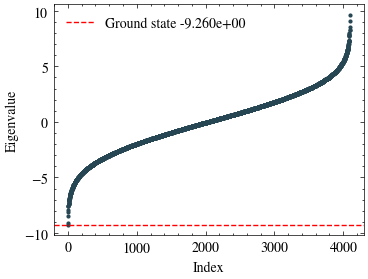

In [31]:
if eigv is not None:
    fig, ax = Plotter.get_subplots(
        nrows       = 1,
        ncols       = 1,
        figsize     = (4, 3),
        dpi         = 100,
    )
    x   = np.arange(0, len(eigv))
    y   = eigv
    ax[0].plot(x, y, 'o', markersize=2)
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Eigenvalue')
    ax[0].axhline(eigv[0], color='r', linestyle='--', label=f'Ground state {eigv[0]:.3e}')
    ax[0].legend()

### Network - variational ansatz body $\psi _\theta (s)$ and its gradient $\nabla \psi _\theta (s)$.

In [32]:
network = 'rbm'
# network = 'cnn'
alpha   = 6
mult    = lattice.ns // (lx * ly)
if network == 'rbm':
    net = RBM(
        input_shape     = st_shape, 
        n_hidden        = int(alpha * ns),
        dtype           = dtypex,
        seed            = seed,
        visible_bias    = False,
        bias            = True,
    )
else:
    net     = CNN(
        input_shape         = st_shape,
        reshape_dims        = (lx, ly * mult),
        features            = (8,) * alpha,
        kernel_sizes        = [(3, 3)] * alpha,
        activations         = [elu_jnp] * alpha,
        dtype               = dtypex,
        param_dtype         = dtypex,
        final_activation    = elu_jnp,
        seed                = seed,
        output_shape        = (1,)
    )
net

12_05_2025_12-26_54 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
12_05_2025_12-26_54 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=936, is_holomorphic=True


ComplexRBM(shape=(12,), hidden=72, bias=on, visible_bias=off, dtype=complex128, params=936, analytic_grad=False, initialized)

### Sampler - sampling from the distribution $p_\theta (s)$.

In [33]:
n_chains        = 5
n_samples       = 200
n_therm_steps   = 25
sampler = Sampler.MCSampler(
                net             = net,
                shape           = st_shape,
                rng             = rng,
                rng_k           = rng_k,
                numchains       = n_chains,
                numsamples      = n_samples,
                sweep_steps     = ns,
                backend         = backend_np,
                therm_steps     = n_therm_steps,
                mu              = 2.0,
                seed            = seed
            )
sampler

MCSampler(shape=(12,), mu=2.0, beta=1.0, therm_steps=25, sweep_steps=12, numsamples=200, numchains=5, backend=jax)

### NQS - neural network quantum state $\psi_\theta (s)$ and its gradient $\nabla \psi_\theta (s)$.

In [72]:
n_epo           = 1000
lr              = 0.05
n_hidden        = 2*ns
n_sweep_steps   = ns
n_batch         = 1

# Other
reg             = 5
maxiter         = 1000
tolerance       = 1e-8
use_min_sr      = False

# Solver
solver_id       = solvers.SolverType.SCIPY_CG
precond_id      = preconditioners.PreconditionersTypeSym.JACOBI
solver          = solvers.choose_solver(solver_id=solver_id, sigma=reg)
precond         = preconditioners.choose_precond(precond_id=precond_id, backend=backend)
precond_apply   = precond.get_apply_gram()

# Stochastic Reconfiguration
sr_options      = SR.SRParams(
                    min_sr        = use_min_sr,
                    maxiter       = maxiter,
                    tol           = tolerance,
                    reg           = reg,
                    solver_form_s = False
                )
solver_linalg_func = solver.get_solver_func(
                        backend_module = backend_np,
                        use_matvec     = False,
                        use_matrix     = False,
                        use_fisher     = True,
                        sigma          = None
                    )

#! Functions
solver_fun      = solver_linalg_func
precond_fun     = precond_apply

solver, precond

12_05_2025_12-41_07 [INFO] 	->[Jacobi Preconditioner] Resetting backend to: jax
12_05_2025_12-41_07 [INFO] 		->[Jacobi Preconditioner] JIT compiling apply_gram(r, S, Sp, ...) function...


(CgSolverScipy(type=SCIPY_CG, backend='jax'),
 Jacobi Preconditioner(sigma=0.0, backend='jax', type=PreconditionersTypeSym.JACOBI, tol_small=1e-13))

In [73]:
nqs =   NQS.NQS(
            net             = net,
            sampler         = sampler,
            hamiltonian     = hamil,
            lower_betas     = None,
            lower_states    = None,
            seed            = seed,
            beta            = 1.0,
            mu              = sampler.get_mu(),
            shape           = st_shape,
            backend         = backend_np,
            nthread         = 1,
            batch_size      = n_batch,
        )
ansatz          = nqs.ansatz
loc_energy      = nqs.local_energy
flat_grad       = nqs.flat_grad
nqs

[1] I am a NQS object with a general Monte Carlo Solver at β =  1.00.

### Test the training of the NQS with a simple Hamiltonian.

In [74]:
def _single_step_jax(params, configs, configs_ansatze, probabilities):
    #! Single step in the NQS (includes ansatz evaluation, local energy computation, and gradient calculation)
    dpar, step_info, (shapes, sizes, iscpx) = nqs.single_step_jax(
                            params               = params,
                            configs              = configs,
                            configs_ansatze      = configs_ansatze,
                            probabilities        = probabilities,
                            apply_fn             = ansatz,
                            local_energy_fun     = loc_energy,
                            flat_grad_fun        = flat_grad,
                            #! Stochastic reconfiguration options
                            use_sr               = True,
                            sr_options           = sr_options,
                            sr_precond_apply_fun = precond_fun,
                            sr_solve_linalg_fun  = solver_fun,
                        )
    return dpar, step_info, (shapes, sizes, iscpx)

#! force compilation
(_, _), (configs, configs_ansatze), probabilities = nqs.sample(reset=True)
single_step_jax = jax.jit(_single_step_jax)
dummy           = single_step_jax(params=nqs.get_params(), configs=configs, configs_ansatze=configs_ansatze, probabilities=probabilities)
# ---
#! timeit
def _timeit(fn, **kwargs):
    """Utility: run fn(*args, **kwargs) and return (result, elapsed_seconds)."""
    t0      = time.time()
    res     = fn(**kwargs)
    # If JAX DeviceArray or tuple thereof, block until ready for accurate timing
    if hasattr(res, "block_until_ready"):
        res.block_until_ready()
    elif isinstance(res, tuple):
        for x in res:
            if hasattr(x, "block_until_ready"):
                x.block_until_ready()
    return res, time.time() - t0

#! Training
def single_step_train(i: int, lr: float, reset: bool=False):
    # 1) Sampling
    ((_, _), (configs, configs_ansatze), probabilities), t_sample = _timeit(nqs.sample, reset=reset)
    # (_, _), (configs, configs_ansatze), probabilities = nqs.sample(reset=reset)

    # 2) Energy + gradient (JIT-compiled)
    params = nqs.get_params()
    (dpar, step_info, (shapes, sizes, iscpx)), t_step = _timeit(_single_step_jax,
                                        params=params, configs=configs, configs_ansatze=configs_ansatze, probabilities=probabilities)

    if step_info.failed:
        logger.error(f"Step {i} failed.")
        return None, None, (t_sample, t_step, 0.0)

    # 3) Parameter update
    _, t_update = _timeit(nqs.update_parameters, d_par=dpar, mult=-lr, shapes=shapes, sizes=sizes, iscpx=iscpx)
    return (step_info.mean_energy, step_info.std_energy), (t_sample, t_step, t_update)

def train_function(n_epo     : int,
                lr           : float = 7e-2,
                decay_rate   : float = 0.999,
                lr_floor     : float = 5e-3,
                reset        : bool = False):

    history      = np.zeros(n_epo, dtype=np.float64)
    history_std  = np.zeros(n_epo, dtype=np.float64)
    times_samp   = np.zeros(n_epo, dtype=np.float64)
    times_step   = np.zeros(n_epo, dtype=np.float64)
    times_update = np.zeros(n_epo, dtype=np.float64)
    pbar         = trange(n_epo, desc="Training", leave=True)

    for i in pbar:
        current_lr = max(lr_floor, lr * (decay_rate ** i))

        (mean_E, std_E), (t_s, t_st, t_u) = single_step_train(i, current_lr, reset)
        if mean_E is None:
            logger.warning(f"Stopped at epoch {i} due to failure.")
            break

        # Log & display
        times_samp[i], times_step[i], times_update[i]   = t_s, t_st, t_u
        history[i], history_std[i]                      = np.real(mean_E), np.real(std_E)

        pbar.set_postfix({
            "E_mean"        :  f"{mean_E:.4e}",
            "lr"            :  f"{current_lr:.1e}",
            "t_sample"      :  f"{t_s:.3e}s",
            "t_step"        :  f"{t_st:.3e}s",
            "t_update"      :  f"{t_u:.3e}s",
            "t_tot"         :  f"{(t_s+t_st+t_u):.3e}s",
        }, refresh=True)

        if np.isnan(mean_E) or np.isnan(std_E):
            logger.warning(f"NaN detected at epoch {i}.")
            break

    # At the end, you can quickly see where time went:
    total = times_samp + times_step + times_update
    print("Time breakdown (fraction of total):")
    print(f"-sampling: {times_samp.sum()/total.sum():.2%}")
    print(f"-compute:  {times_step.sum()/total.sum():.2%}")
    print(f"-update:   {times_update.sum()/total.sum():.2%}")

    return (history[:i+1],
            history_std[:i+1],
            total[:i+1])

In [76]:
history, history_std, epoch_times = train_function(n_epo    = n_epo,
            lr          = lr,
            reset       = False,
            decay_rate  = 0.999
            )

Training: 100%|██████████| 1000/1000 [05:14<00:00,  3.17it/s, E_mean=-8.2264e+00+2.8406e-02j, lr=1.8e-02, t_sample=1.432e-01s, t_step=1.217e-01s, t_update=2.549e-04s, t_tot=2.652e-01s]

Time breakdown (fraction of total):
-sampling: 46.02%
-compute:  53.90%
-update:   0.08%


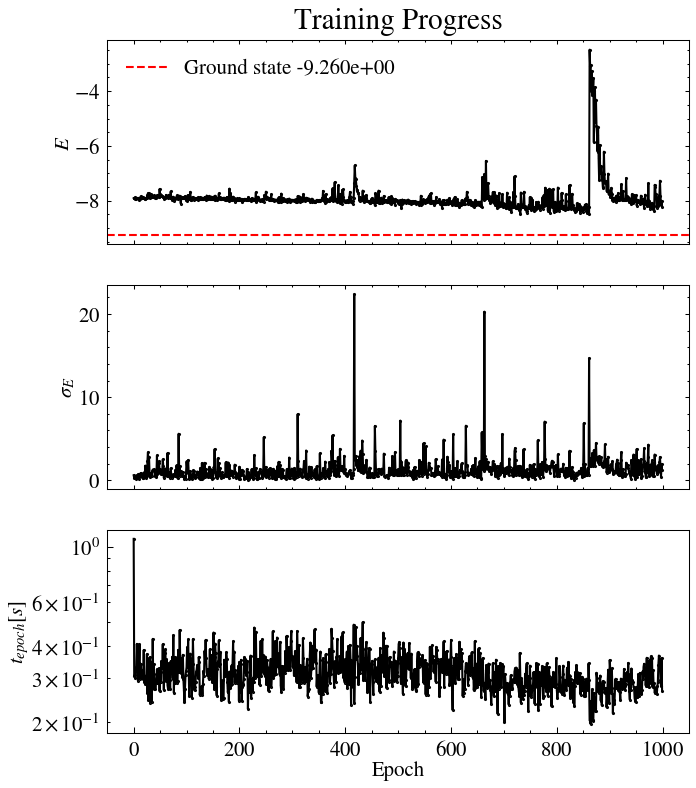

In [77]:
energies        = history[~np.isnan(history)]
energies_std    = history_std[~np.isnan(history_std)]
fig, ax         = Plotter.get_subplots(nrows=3, ncols=1, figsize=(5, 6), dpi=150, sharex=True)
Plotter.plot(ax[0], x=np.arange(len(energies)), y=np.real(energies), marker="o", markersize=0.5, lw=1)
if eigv is not None:
    ax[0].axhline(eigv[0], color='r', linestyle='--', label=f'Ground state {eigv[0]:.3e}')
    ax[0].legend()
Plotter.set_ax_params(ax[0], title="Training Progress", ylabel=r"$E$")
Plotter.set_tickparams(ax[0], maj_tick_l=2, min_tick_l=1)


Plotter.plot(ax[1], x=np.arange(len(energies_std)), y=np.real(energies_std), marker="o", markersize=0.5, lw=1)
Plotter.set_ax_params(ax[1], ylabel=r"$\sigma_E$")
Plotter.set_tickparams(ax[1], maj_tick_l=2, min_tick_l=1)

Plotter.plot(ax[2], x=np.arange(len(epoch_times)), y=np.real(epoch_times), marker="o", markersize=0.5, lw=1)
Plotter.set_ax_params(ax[2], xlabel="Epoch", ylabel=r"$t_{epoch} [s]$", yscale="log")